In [97]:
from commonfunctions import *
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import os
import utlis
from sklearn import datasets, svm, metrics
import scipy
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
try:
    from PIL import Image 
except ImportError:
    import Image
import pytesseract
os.system("clear")
from skimage.transform import rescale,resize,downscale_local_mean
pytesseract.pytesseract.tesseract_cmd = r"C:\Users\ahmed\AppData\Local\Programs\Tesseract-OCR\tesseract.exe"


# Functions 

In [98]:
# Functions [show, scann]

def _imshow(img):
    cv2.imshow('image', img)
    plt.show()
    # specify a wait key from keyboard
    k = cv2.waitKey(0) & 0xFF

    if k == 27: #esc in keyboard
        cv2.destroyAllWindows() #close the window   

    elif k == ord('s'): #if order is s save the image
        cv2.imwrite('Test.png', img) #write image in your pc     
        cv2.destroyAllWindows() # close the window 

def _scannar(img, m = 10):
    heightImg = img.shape[1]
    widthImg  = img.shape[0]
    imgBlank = np.zeros((heightImg,widthImg, 3), np.uint8) # CREATE A BLANK IMAGE FOR TESTING DEBUGING IF REQUIRED
    # imgGray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # CONVERT IMAGE TO GRAY SCALE
    imgBlur = cv2.GaussianBlur(img, (3, 3), 1) # ADD GAUSSIAN BLUR
    imgBlur = img

    imgsobel = sobel(imgBlur)
    imgThreshold = cv2.Canny(imgBlur,100,150) # APPLY CANNY BLUR
    kernel = np.ones((3, 3))
    imgDial = cv2.dilate(imgThreshold, kernel, iterations=2) # APPLY DILATION
    imgThreshold = cv2.erode(imgDial, kernel, iterations=1)  # APPLY EROSION



    ## FIND ALL COUNTOURS
    imgContours = img.copy() # COPY IMAGE FOR DISPLAY PURPOSES
    imgBigContour = img.copy() # COPY IMAGE FOR DISPLAY PURPOSES
    contours, hierarchy = cv2.findContours(imgThreshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) # FIND ALL CONTOURS
    cv2.drawContours(imgContours, contours, -1, (0, 255, 0), 10) # DRAW ALL DETECTED CONTOURS
    imgThreshold = cv2.cvtColor(imgThreshold,cv2.COLOR_BAYER_BG2BGR)


    # FIND THE BIGGEST COUNTOUR
    biggest, maxArea = utlis.biggestContour(contours) # FIND THE BIGGEST CONTOUR

    if biggest.size != 0:
        biggest=utlis.reorder(biggest)
        cv2.drawContours(imgBigContour, biggest, -1, (0, 255, 0), 20) # DRAW THE BIGGEST CONTOUR
        imgBigContour = utlis.drawRectangle(imgBigContour,biggest,2)
        pts1 = np.float32(biggest) # PREPARE POINTS FOR WARP
        pts2 = np.float32([[0, 0],[widthImg, 0], [0, heightImg],[widthImg, heightImg]]) # PREPARE POINTS FOR WARP
        matrix = cv2.getPerspectiveTransform(pts1, pts2)
        imgWarpColored = cv2.warpPerspective(img, matrix, (widthImg, heightImg))

        #REMOVE 20 PIXELS FORM EACH SIDE
        imgWarpColored=imgWarpColored[m:imgWarpColored.shape[0] +150, m:imgWarpColored.shape[1] +150 ]

        # APPLY ADAPTIVE THRESHOLD
        # imgAdaptiveThre= cv2.adaptiveThreshold(imgWarpColored, 255, 1, 1, 7, 2)
        img = cv2.adaptiveThreshold(imgWarpColored,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,85,12)

        # imgAdaptiveThre = cv2.bitwise_not(imgAdaptiveThre)
        # imgAdaptiveThre=cv2.medianBlur(imgWarpColored,3)

    # thres = 130
    # img_bin = np.copy(imgAdaptiveThre)
    # img_bin[imgAdaptiveThre < thres] = 0
    # img_bin[imgAdaptiveThre >= thres] = 255
    # img = img_bin
    # _imshow(img)
    return img


def sort_contours(cnts, method="left-to-right"):
    # initialize the reverse flag and sort index
    reverse = False
    i = 0
    # handle if we need to sort in reverse
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
    # handle if we are sorting against the y-coordinate rather than
    # the x-coordinate of the bounding box
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    # construct the list of bounding boxes and sort them from top to
    # bottom
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes), key=lambda b: b[1][i], reverse=reverse))
    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

# def remove_pixels()

# Read Scanne an Image

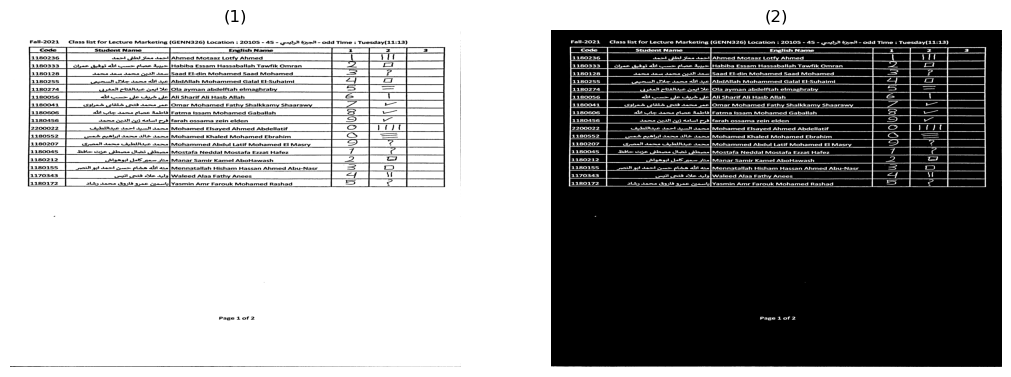

(2974, 3980)


In [99]:
# Read scan image


# read your file
img_num = 1

file = f"E:\CUFE\Fall22\IP\Project-2022\GradesAutoFiller-main\GradesAutoFiller-main\Module1\dataSet\{img_num}.jpg"
img = cv2.imread(file,1)
## resize image if needed
# img = cv2.resize(img,None,fx = 2,fy = 2)
img = cv2.resize(img,(2984,3990))
# img = resize(img,(2984,3990))

# convert to gray scale image 
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
## applay adaptive threshold for images that have different priattness 
# img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,85,10)

# scan image 
m = 10 
if img_num == 3:
    m = 0
img_sc = _scannar(img,m = m) 
# show_images([img_sc])
# thresholding the image to a binary image
thresh, img_bin = cv2.threshold(img_sc, 200, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

# inverting the image
# img_sc = img_bin
img_bin = 255-img_bin

# show images
# _imshow(img)
# _imshow(img_sc)
show_images([img_sc,img_bin])
print(img_sc.shape)



## Get Cells of the Table

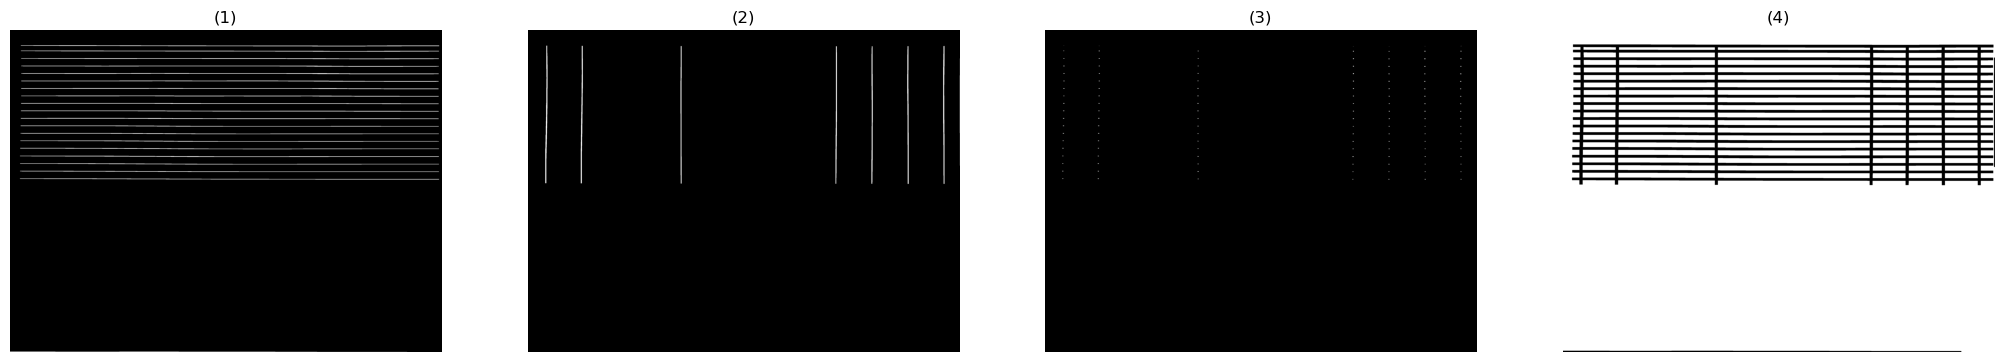

In [100]:
# Get table stracture 
######################################

# countcol(width) of kernel as 100th of total width
kernel_len = np.array(img_sc).shape[0]//360
# Defining a vertical kernel to detect all vertical lines of image
ver_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_len))
# Defining a horizontal kernel to detect all horizontal lines of image
hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_len+8, 1))
# A kernel of 2x2
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (6, 6))

# Use vertical kernel to detect and save the vertical lines in a jpg
vlines = cv2.erode(img_bin, ver_kernel, iterations=20)
vertical_lines = cv2.dilate(vlines, ver_kernel, iterations=25)
vertical_lines = np.array(vertical_lines)

# Use horizontal kernel to detect and save the horizontal lines in a jpg
hlines = cv2.erode(img_bin, hor_kernel, iterations=18)
horizontal_lines = cv2.dilate(hlines, hor_kernel, iterations=30)
horizontal_lines = np.array(horizontal_lines)

# Combine horizontal and vertical lines in a new third image, with both having same weight.
img_vh = cv2.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0.0)
# Eroding and thesholding the image
img_vh = cv2.erode(~img_vh, kernel, iterations=4)
thresh, img_vh = cv2.threshold(img_vh, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

# get intersection
# vh_points = np.zeros((img_sc.shape[1],img_sc.shape[0])) 
vh_points = cv2.bitwise_and(horizontal_lines,vertical_lines)

# _imshow(vh_points)
# Plotting the generated image
show_images([horizontal_lines,vertical_lines,vh_points ,img_vh])


7
[ 159  159  159 ... 3836 3836 3836] [ 159  486 1405 2833 3164 3494 3825]


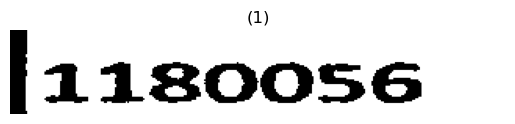

(54, 317)


In [101]:
# Table stracture 
yx_coords = np.column_stack(np.where(vh_points == 255))
y = np.sort(yx_coords[:,0])
x = np.sort(yx_coords[:,1])

ref = 0 
count = 1
xc = np.copy(x)
for i in range(1,len(x)):

    # if (i == len(x)-1):
    #     break
    if ((x[i] - x[ref]) < 25):
        xc[i] = -1
        count += 1  
    else:
        ref = ref + count 
        count = 1
    if (ref >= len(x)):
        break

ref = 0 
count = 1
yc = np.copy(y)
for i in range(1,len(y)):

    # if (i == len(x)-1):
    #     break
    if ((y[i] - y[ref]) < 25):
        yc[i] = -1
        count += 1  
    else:
        ref = ref + count 
        count = 1
    if (ref >= len(y)):
        break

xc = xc[xc !=  -1]
yc = yc[yc !=  -1]
print(len(xc))
print(x,xc[:10])

y = yc
x = xc
i =0
j = 6
ml = 15
mt = 10
img2 = img_sc[yc[j]+ml:yc[j+1], xc[i]+mt:xc[i+1]  ]
_, img2 = cv2.threshold(img2, 60, 255, cv2.THRESH_BINARY )

show_images([img2])

print(img2.shape)


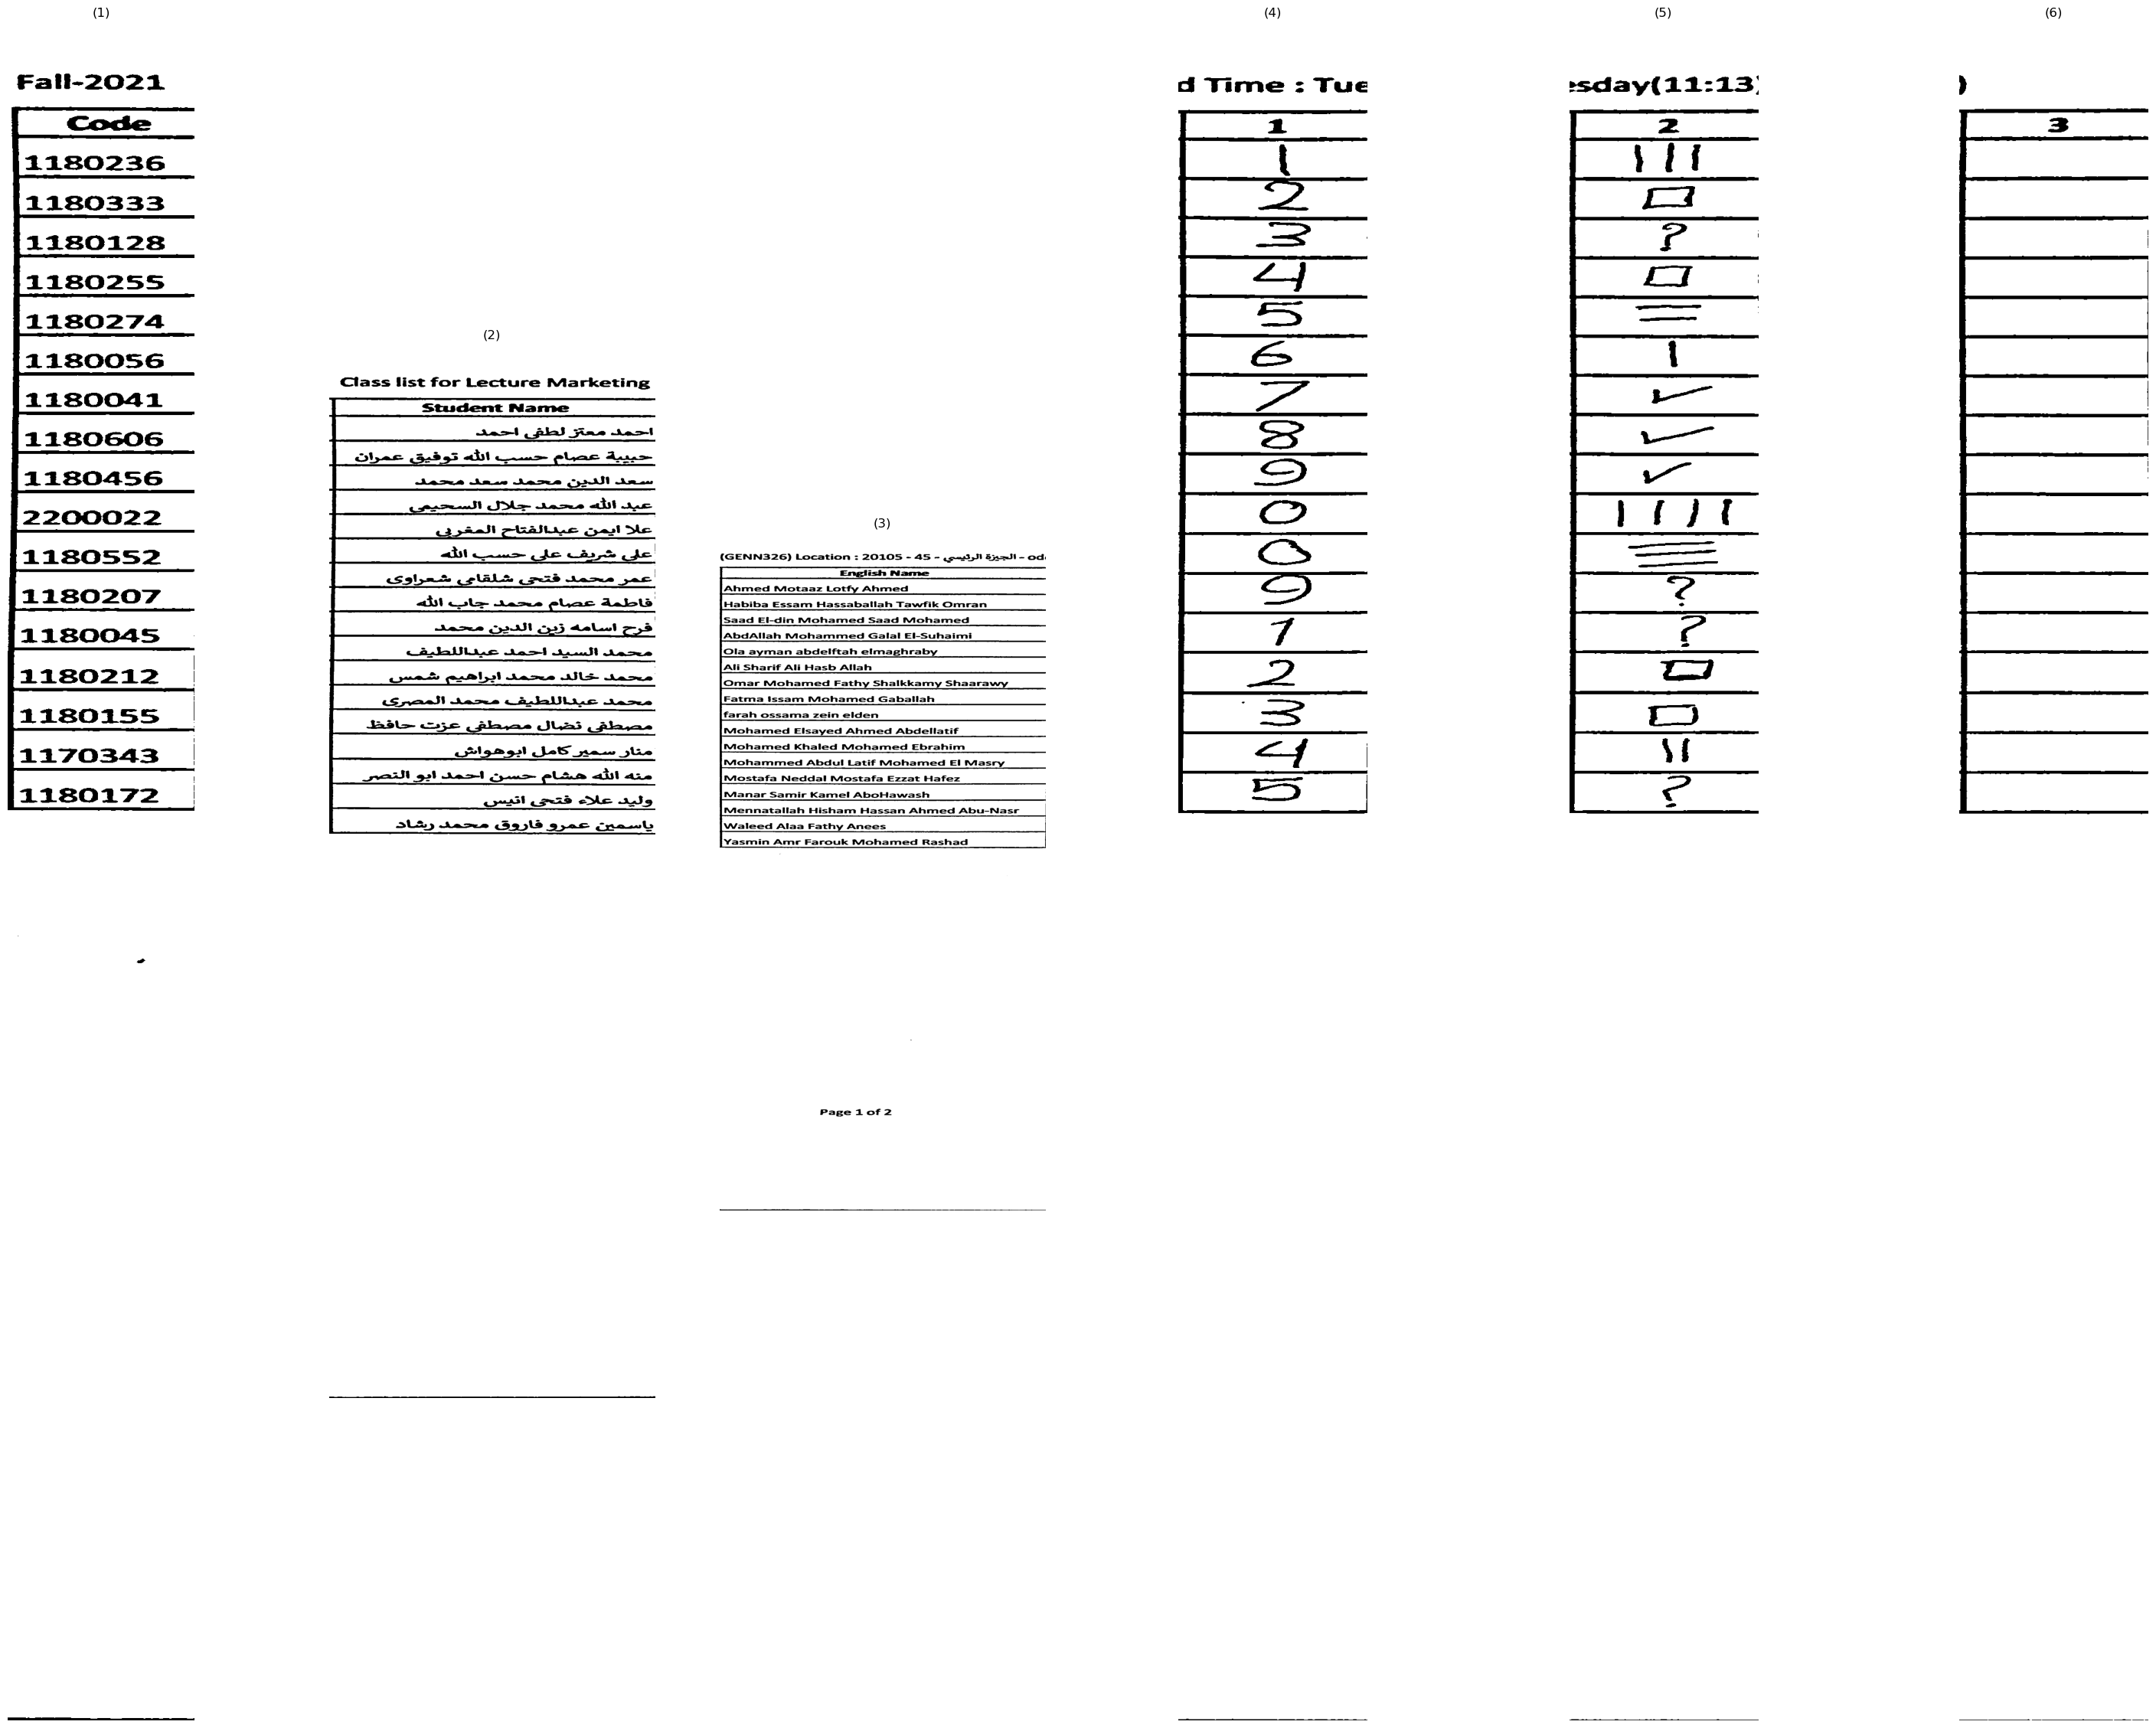

In [102]:
code = img_sc[:,x[0]:x[1]]
ar_name = img_sc[:,x[1]:x[2]]
eng_name = img_sc[:,x[2]:x[3]]
col1 = img_sc[:,x[3]:x[4]]
col2 = img_sc[:,x[4]:x[5]]
col3 = img_sc[:,x[5]:x[6]]

show_images([code,ar_name,eng_name,col1,col2,col3])


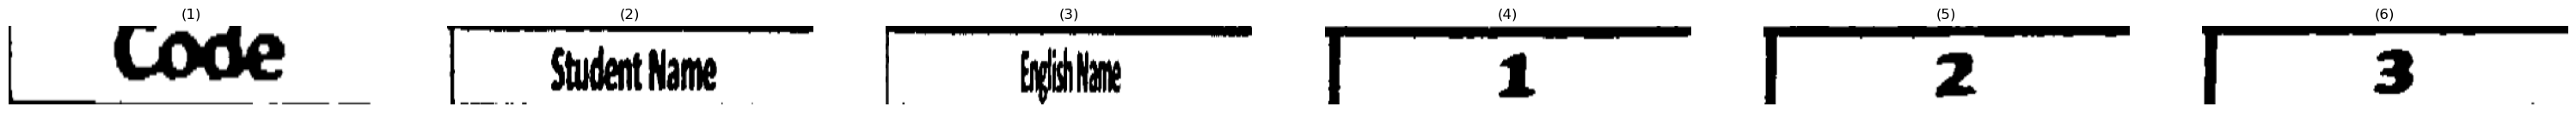

In [103]:
codes = []
ar_names = []
eng_names = []
cols1 = []
cols2 = []
cols3= []
ml = 15
mr = 0
mu = 15
mb = 0
se = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
# extract each col 
for i in range(1,len(y)):
    code = img_sc[y[i-1]+mu:y[i]+mb,x[0]+ml:x[1]+mr]
    ar_name = img_sc[y[i-1]:y[i],x[1]:x[2]]
    eng_name = img_sc[y[i-1]:y[i],x[2]:x[3]]
    col1 = img_sc[y[i-1]:y[i],x[3]:x[4]]
    col2 = img_sc[y[i-1]:y[i],x[4]:x[5]]
    col3 = img_sc[y[i-1]:y[i],x[5]:x[6]]
    
    code = cv2.resize(code,(327,70))
    ar_name = cv2.resize(ar_name,(327,70))
    eng_name = cv2.resize(eng_name,(327,70))
    col1 = cv2.resize(col1,(327,70))
    col2 = cv2.resize(col2,(327,70))
    col3 = cv2.resize(col3,(327,70))
    
    # _,code = cv2.threshold(code,150,255,cv2.THRESH_BINARY)

    code = cv2.dilate(code, se, iterations=1)


    codes.append(code)
    ar_names.append(ar_name)
    eng_names.append(eng_name)
    cols1.append(col1)
    cols2.append(col2)
    cols3.append(col3)
#     show_images([code])

# show_images([code[:]])
show_images([codes[0],ar_names[0],eng_names[0],cols1[0],cols2[0],cols3[0]])


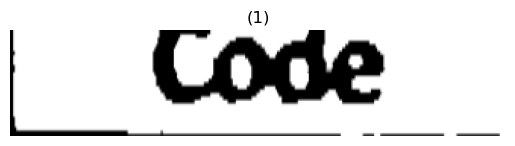

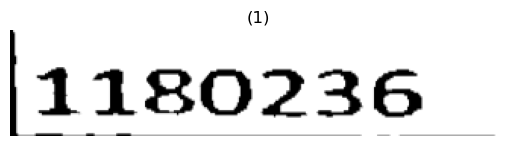

1180236



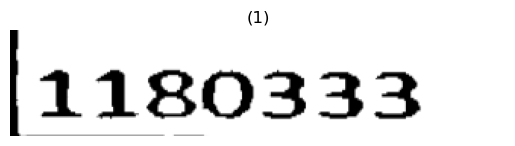

1180333



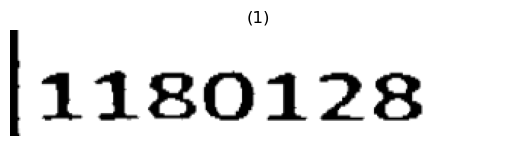

1180128



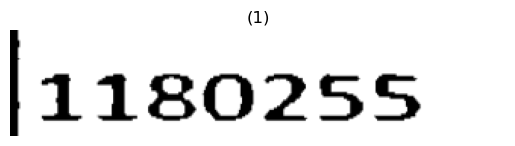

1180255



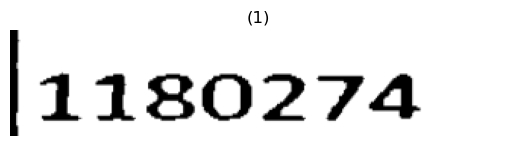

1180274



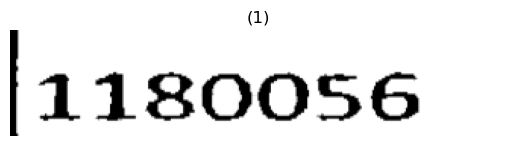

1180056



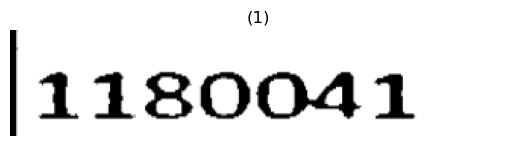

1180041



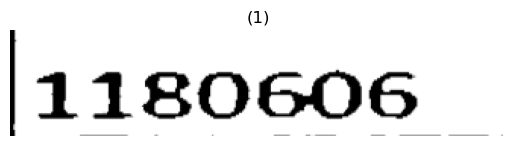

1180606



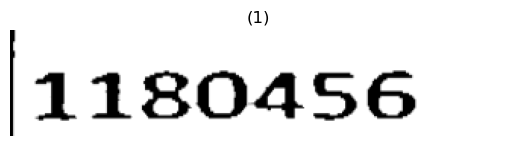

1180456



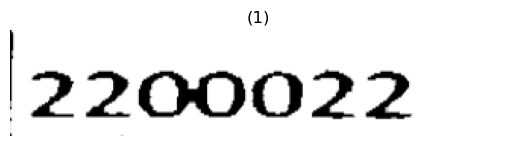

2200022



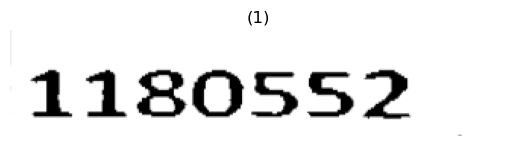

1180552



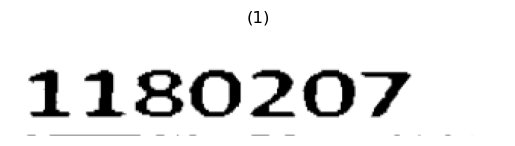

1180207



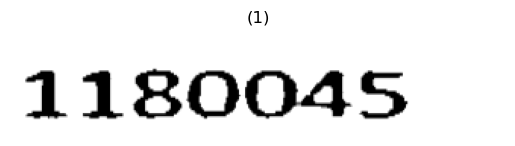

1180045



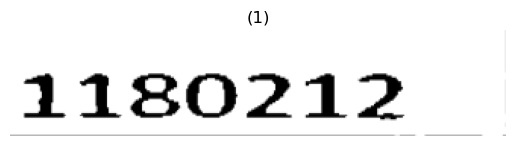

1180212



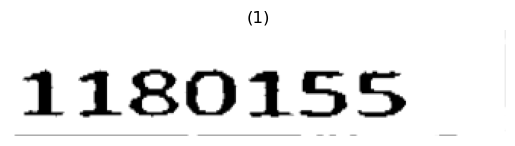

1180155



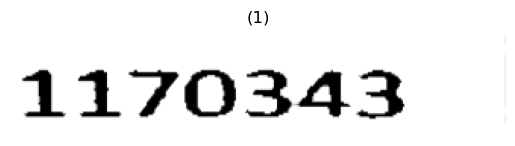

1170343



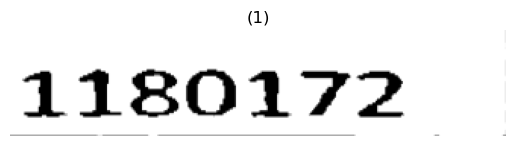

1180172



In [104]:
for i in range(len(codes)):
    show_images([codes[i]])
    code_text = pytesseract.image_to_string(codes[i], config = "8")
    print(code_text)


In [105]:

# Extract codes using ocr 

excel_code = []
excel_names = []
for i in range (len(codes)):
    code_text = pytesseract.image_to_string(codes[i], config = "8")
    name_text = pytesseract.image_to_string(eng_names[i], config = "8")
    excel_code.append(code_text)
    excel_names.append(name_text)
#     print(code_text,name_text)
print(excel_code)

['', '1180236\n', '1180333\n', '1180128\n', '1180255\n', '1180274\n', '1180056\n', '1180041\n', '1180606\n', '1180456\n', '2200022\n', '1180552\n', '1180207\n', '1180045\n', '1180212\n', '1180155\n', '1170343\n', '1180172\n']


In [106]:
# save data for symoble col to use them in ML model

# for i in range(len(codes)):
#     show_images([cols2[i]])

# for i in range(len(codes)):
#     io.imsave(f"E:\CUFE\Fall22\IP\Project-2022\GradesAutoFiller-main\GradesAutoFiller-main\Module1\AllCells/img{img_num}_sym{i}_col_{1}.jpeg",cols1[i])


# ML Model

In [107]:
# KNN trail 2

path = "E:\CUFE\Fall22\IP\Project-2022\GradesAutoFiller-main\GradesAutoFiller-main\Module1\Module1\DataSets\TrainData/"
files = os.listdir(path)
print(files)

classes = {'s':0,'r':1,'q':2}

['q', 'r', 's']


In [108]:
X = []
Y = []

for cl in classes:
    pth = path+cl
    for img_name in os.listdir(pth):
        img = cv2.imread(pth + '/' + img_name,0)
        X.append(img)
        Y.append(classes[cl])
print('dataset created successfully')

dataset created successfully


In [109]:
pd.Series(Y).value_counts()

1    223
0    216
2    132
dtype: int64

In [110]:
X[0].shape
print(type(X))
X = np.array(X)
Y = np.array(Y)
print(type(X))

<class 'list'>
<class 'numpy.ndarray'>


2


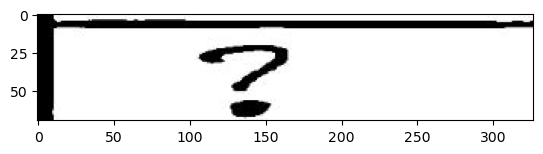

In [111]:
plt.imshow(X[500],cmap= "gray")
print(Y[500])   

In [112]:
print(X.shape,Y.shape)

(571, 70, 327) (571,)


In [113]:
X_new = X.reshape(len(X),-1)
print(X_new.shape)
print(X.ndim)
print(X_new.ndim)

(571, 22890)
3
2


### Split Data

In [114]:
xtrain, xtest, ytrain, ytest = train_test_split(X_new,Y,test_size = 0.20, random_state = 10)

In [115]:
print(xtrain.shape,ytrain.shape)
print(xtest.shape, ytest.shape)

(456, 22890) (456,)
(115, 22890) (115,)


### Feature Scaling

In [116]:
print(xtrain.max())
print(xtest.max())
x_train = xtrain/255
x_test = xtest/255
print(x_train.max())
print(x_test.max())

255
255
1.0
1.0


### Feature Selection: PCA

In [117]:
print(x_train.shape, x_test.shape)
pca = PCA(.98)
xtrain = pca.fit_transform(x_train)
xtest = pca.transform(x_test)
print(x_train.shape, x_test.shape)
print(pca.n_components)
print(pca.n_features_)


(456, 22890) (115, 22890)
(456, 22890) (115, 22890)
0.98
22890


In [118]:
ytest[:10]

array([0, 1, 1, 1, 2, 0, 2, 0, 1, 0])

### Train The model 

In [119]:
log = LogisticRegression()
log.fit(xtrain, ytrain)

LogisticRegression()

### Prediction

In [120]:
tr_pred = log.predict(xtrain)
ts_pred = log.predict(xtest)

In [121]:
print("Training Score", accuracy_score(ytrain,tr_pred))
print("Testing Score",accuracy_score(ytest,ts_pred))

Training Score 1.0
Testing Score 0.991304347826087


0


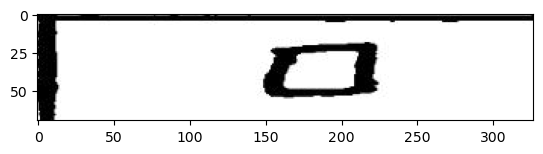

In [122]:
plt.imshow(x_test[0].reshape(70,327),cmap = 'gray')
print(ytest[0])

### Test Model

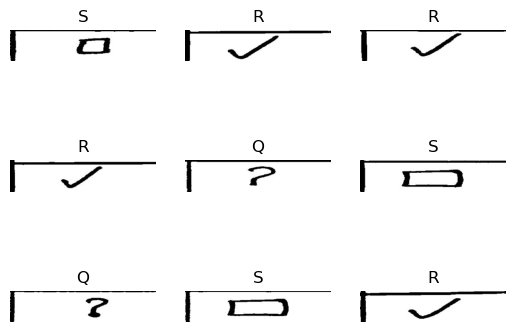

In [123]:
decode = {0:'S',1:'R',2:'Q'}
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(x_test[i].reshape(70,327), cmap = 'gray')
    plt.title(decode[ts_pred[i]])
    plt.axis('off')
    

# Data to Excel

In [124]:
np.where(ts_pred!=ytest)
d = pd.DataFrame({'Actual':ytest,'Prediction':ts_pred})
d[d['Actual'] != d['Prediction']]

,Actual,Prediction
63,0,1


In [125]:
# img2 = cv2.resize(cv2.imread("E:\CUFE\Fall22\IP\Project-2022\GradesAutoFiller-main\GradesAutoFiller-main\Module1\cells\check\ii (34).jpeg",0), (327,70))




# Handwritten Digit Recogniton

In [126]:
# digits = datasets.load_digits()
# print(digits.DESCR)
pathd = "E:\CUFE\Fall22\IP\Project-2022\GradesAutoFiller-main\GradesAutoFiller-main\Module1\Module1\DataSets\digits\digits/"
filesd = os.listdir(pathd)
print(filesd)

classesd = {'0':0,'1':1,'2':2,'3':3,'4':4,'5':5,'6':6,'7':7,'8':8,'9':9}

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [127]:
Xd = []
yd = []

for cl in classesd:
    pthd = pathd+cl
    for img_name in os.listdir(pthd):
        img = cv2.imread(pthd + '/' + img_name,0)
        Xd.append(img)
        yd.append(classesd[cl])
print('dataset created successfully')

dataset created successfully


In [128]:
pd.Series(yd).value_counts()


3    24
2    23
4    22
5    22
6    22
0    20
9    20
8    16
7    15
1    13
dtype: int64

In [129]:
# Xd = digits.images
# Xd = 255 - Xd
# yd = digits.target
# Xd.shape
# plt.imshow(Xd[1], cmap= plt.get_cmap('gray'))
# print(yd[1])

Xd[0].shape
print(type(Xd))
Xd = np.array(Xd)
yd = np.array(yd)
print(type(Xd))


<class 'list'>
<class 'numpy.ndarray'>


In [130]:
Xd.shape
print(type(yd))
yd.shape

Xd_new = Xd.reshape(len(Xd),-1)
print(Xd_new.shape)
print(Xd.ndim)
print(Xd_new.ndim)
print(Xd.shape)

<class 'numpy.ndarray'>
(197, 22890)
3
2
(197, 70, 327)


In [131]:
# df = pd.DataFrame(data = yd, columns=['targets'])


In [132]:
# print(x1.shape,y1.shape, digits.images.shape)
# # plt.imshow(digits.images[0], cmap= plt.cm.gray_r)
# # plt.axis('off')

# figure, axes = plt.subplots(3,10,figsize = (15,6))

# for ax,image,number in zip(axes.ravel(),digits.images,y1):
#     ax.axis('off')
#     ax.imshow(image, cmap = plt.cm.gray_r)
#     ax.set_title("Number: " + str(number))

In [133]:
# image = digits.images[0]
# print('original image data = ')
# print(image)
# print()

# image_flattened = image.ravel()
# print('image_flattened = ')
# print(image_flattened)
# print()

# print('feature data for a sample = ')
# print(Xd[0])
# print()

# print("feature data for all sampes is a 8 by 8 two dimensional array ")
# print(Xd)

In [134]:
xdtrain, xdtest, ydtrain, ydtest = train_test_split(Xd_new, yd, test_size=0.20,random_state=10)

In [135]:
print(xdtrain.shape,xdtest.shape,ydtrain.shape,ydtest.shape)

(157, 22890) (40, 22890) (157,) (40,)


In [136]:
print(xdtrain.max())
print(xdtest.max())
xd_train = xdtrain/255
xd_test = xdtest/255
print(xd_train.max())
print(xd_test.max())
xdtrain.shape

255
255
1.0
1.0


(157, 22890)

### Fit the model

In [137]:
# knn = KNeighborsClassifier(n_neighbors=3)
# knn.fit(xd_train,ydtrain)
print(xd_train.shape, xd_test.shape)
pcad = PCA(.98)
xdtrain = pcad.fit_transform(xd_train)
xdtest = pcad.transform(xd_test)
print(xd_train.shape, xd_test.shape)
print(pcad.n_components)
print(pcad.n_features_)

(157, 22890) (40, 22890)
(157, 22890) (40, 22890)
0.98
22890


In [138]:
ytest[:10]

array([0, 1, 1, 1, 2, 0, 2, 0, 1, 0])

In [139]:
# plt.imshow(xd_test[359].reshape(8,8),cmap = 'gray')
# print(ydtest[359])
logd = LogisticRegression()
logd.fit(xdtrain, ydtrain)

LogisticRegression()

In [140]:
trd_pred = logd.predict(xdtrain)
tsd_pred = logd.predict(xdtest)
print("Training Score", accuracy_score(ydtrain,trd_pred))
print("Testing Score",accuracy_score(ydtest,tsd_pred))

Training Score 1.0
Testing Score 0.9


In [141]:
execl_col2 = ['2']
for i in range(1,len(cols2)):
    img2 = cols2[i]
#     plt.imshow(img2,cmap='gray')
    img2 = pca.transform(img2.reshape(1,-1)/255)      
    # print(i, decode[log.predict(img2)[0]] )
    execl_col2.append(decode[log.predict(img2)[0]])
print(execl_col2)

execl_col3 = ['3']
for i in range(1,len(cols2)):
    img2 = cols3[i]
#     plt.imshow(img2,cmap='gray')
    img2 = pca.transform(img2.reshape(1,-1)/255)      
    # print(i, decode[log.predict(img2)[0]] )
    execl_col3.append(decode[log.predict(img2)[0]])
print(execl_col3)

execl_col3 = np.array(execl_col3)
execl_col2 = np.array(execl_col2)

execl_col3[execl_col3 == 'Q'] = 'C'
execl_col3[execl_col3 == 'R'] = 5
execl_col3[execl_col3 == 'S'] = 0

execl_col2[execl_col2 == 'Q'] = 'C'
execl_col2[execl_col2 == 'R'] = 5
execl_col2[execl_col2 == 'S'] = 0

print(execl_col3)
print(execl_col2)

##################################################
decoded = {0:'0',1:'1',2:'2',3:'3',4:'4',5:'5',6:'6',7:'7',8:'8',9:'9'}


execl_col1 = ['1']
for i in range(1,len(cols1)):
    img34 = cols1[i]
#     plt.imshow(img2,cmap='gray')
    img34 = pcad.transform(img34.reshape(1,-1)/255)

    # print(i, decode[log.predict(img2)[0]] )
    execl_col1.append(decoded[logd.predict(img34)[0]])
print(execl_col1)



['2', 'S', 'S', 'Q', 'S', 'S', 'Q', 'R', 'R', 'R', 'S', 'S', 'Q', 'Q', 'S', 'S', 'Q', 'Q']
['3', 'Q', 'Q', 'Q', 'R', 'Q', 'Q', 'Q', 'Q', 'Q', 'Q', 'Q', 'Q', 'Q', 'Q', 'Q', 'Q', 'Q']
['3' 'C' 'C' 'C' '5' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C']
['2' '0' '0' 'C' '0' '0' 'C' '5' '5' '5' '0' '0' 'C' 'C' '0' '0' 'C' 'C']
['1', '1', '2', '3', '4', '5', '6', '2', '5', '5', '0', '5', '5', '1', '0', '8', '0', '5']


In [142]:

print(len(excel_code),len(excel_names),len(execl_col2),len(execl_col3))
ex_matrix = [excel_code,excel_names,execl_col1,execl_col2,execl_col3]
ex_matrix = np.array(ex_matrix)
ex_matrix = ex_matrix.transpose()
dataframe = pd.DataFrame(ex_matrix)
# print(dataframe)
data = dataframe.style.set_properties(align="left")
# Converting it in a excel-file
data.to_excel("E:\CUFE\Fall22\IP\Project-2022\GradesAutoFiller-main\GradesAutoFiller-main\Module1\Module1\output.xlsx",index=None,header="code")


18 18 18 18


### Evaluate 

In [143]:
# report = classification_report(y1_test, y1_pred)
# # print(report)
# asdf = knn.predict(cols1[2])

# Try to define square using corner detection 

In [144]:
# try to define square using corner detection 
# img = cv2.imread("E:\CUFE\Fall22\IP\Project-2022\GradesAutoFiller-main\GradesAutoFiller-main\Module1\AllCells\img4_sym6_col_2.jpeg")
# gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
# gray = np.float32(gray)

# corners = cv2.goodFeaturesToTrack(gray, 6, 0.01, 30)
# corners = np.int0(corners)

# for corner in corners:
#     x,y = corner.ravel()
#     cv2.circle(img,(x,y),3,255,-1)
    
# show_images([img])

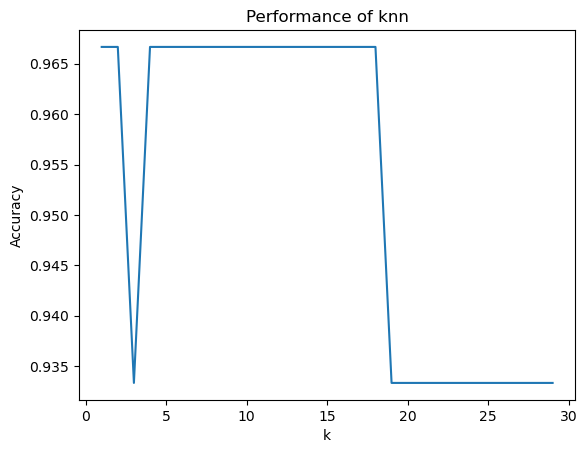

In [145]:
# KNN 
def most_common(lst):
    return max(set(lst), key=lst.count)
def euclidean(point, data):
    # Euclidean distance between points a & data
    return np.sqrt(np.sum((point - data)**2, axis=1))
class KNeighborsClassifier:
    def __init__(self, k=5, dist_metric=euclidean):
        self.k = k
        self.dist_metric = dist_metric
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
    def predict(self, X_test):
        neighbors = []
        for x in X_test:
            distances = self.dist_metric(x, self.X_train)
            y_sorted = [y for _, y in sorted(zip(distances, self.y_train))]
            neighbors.append(y_sorted[:self.k])
        return list(map(most_common, neighbors))
    def evaluate(self, X_test, y_test):
        y_pred = self.predict(X_test)
        accuracy = sum(y_pred == y_test) / len(y_test)
        return accuracy
# Unpack the iris dataset, from UCI Machine Learning Repository
iris = datasets.load_iris()
X = iris['data']
y = iris['target']
# Split data into train & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# Preprocess data
ss = StandardScaler().fit(X_train)
X_train, X_test = ss.transform(X_train), ss.transform(X_test)
# Test knn model across varying ks
accuracies = []
ks = range(1, 30)
for k in ks:
    knn = KNeighborsClassifier(k=k)
    knn.fit(X_train, y_train)
    accuracy = knn.evaluate(X_test, y_test)
    accuracies.append(accuracy)
# Visualize accuracy vs. k
fig, ax = plt.subplots()
ax.plot(ks, accuracies)
ax.set(xlabel="k",
       ylabel="Accuracy",
       title="Performance of knn")
plt.show()